In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [2]:
from gdeep.topactivation.attack_carlini_wagner_l2 import AttackCarliniWagnerL2

In [3]:
#Trainig the model 

arch = [28*28, 50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2

#for i in range(epochs):
    #Train : 
pipe.train(optimizer, epochs, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
   
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())



Epoch 1
-------------------------------
Epoch training loss: 1.342672 	Epoch training accuracy: 59.03%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 83.62%,                 Avg loss: 0.537760 

Epoch 2
-------------------------------
Epoch training loss: 0.412013 	Epoch training accuracy: 87.66%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.22%,                 Avg loss: 0.333322 



In [4]:
import torchattacks
#help(torchattacks.PGD)



In [56]:
#import torchattacks
#atk = torchattacks.CW(pipe.model,kappa=0,c=1)
#atk2 = torchattacks.FGSM(pipe.model, eps=8/255, steps=40, random_start=True)
#atk3 = torchattacks.FGSM(pipe.model,eps=0.3)
#atk=AttackCarliniWagnerL2()

from foolbox import PyTorchModel
from foolbox.attacks import L2CarliniWagnerAttack
atk = L2CarliniWagnerAttack()
epsilons = [2.0
    ]

for a in dl_ts:
    perm = torch.randperm(len(a[1])).to(DEVICE)
    print(a[0].shape)
    print(a[1].shape)
    fmodel = PyTorchModel(pipe.model, bounds=(0, 1), preprocessing=None)
    #adv_images = atk.run(pipe.model,a[0].to(DEVICE),a[1][perm].to(DEVICE))
    print('ok')
    raw_advs, clipped_advs, success = atk(fmodel, a[0].to(DEVICE), a[1].to(DEVICE),epsilons=epsilons)
    
   
    break 

torch.Size([32, 1, 28, 28])
torch.Size([32])
ok


In [53]:
success

tensor([[False, False, False, False,  True, False,  True,  True,  True,  True,
         False,  True,  True, False, False,  True,  True, False,  True,  True,
          True, False,  True, False,  True, False, False,  True, False,  True,
         False,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]], device='cuda:0')

In [34]:
raw_advs[0].shape

torch.Size([32, 1, 28, 28])

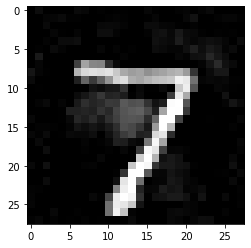

In [54]:
print28x28tensor(raw_advs[1][0]) 

In [47]:
a[1][perm]

tensor([1, 9, 5, 6, 7, 1, 4, 3, 4, 4, 6, 9, 4, 1, 9, 5, 3, 9, 1, 0, 0, 0, 7, 9,
        7, 2, 6, 4, 5, 1, 0, 0])

In [48]:
idx= 8
print(pipe.model(a[0][idx].to(DEVICE)).argmax())
print(pipe.model(raw_advs[0][idx].to(DEVICE)).argmax())

tensor(6, device='cuda:0')
tensor(6, device='cuda:0')


In [26]:
a[0][1].shape

torch.Size([1, 28, 28])

In [55]:
(a[0][1]-raw_advs[0][1].to('cpu')).norm()

tensor(1.1846)

In [ ]:
print28x28tensor(a[0][1]) 

In [ ]:
epsilon = 0.2
n_batch = 1 #Number of batch used to generate the dataset 


activ = torch.zeros((3,n_batch*32,sum(arch)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(5,n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

from foolbox import PyTorchModel
from foolbox.attacks import L2CarliniWagnerAttack
atk = L2CarliniWagnerAttack()
epsilons = [2.0]
fmodel = PyTorchModel(pipe.model, bounds=(0, 1), preprocessing=None)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    perm = torch.randperm(len(target)).to(DEVICE)
    

    raw_advs, clipped_advs, success = atk(fmodel, a[0].to(DEVICE), a[1].to(DEVICE),epsilons=epsilons)
    data_carlini = raw_advs[0]
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    data_noised2 = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
        data_noised2[i]=(rdata_carlini-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    activ[3][k_batch*32:(k_batch+1)*32]=
    activ[2][k_batch*32:(k_batch+1)*32]=
    
    label[k_batch*32:(k_batch+1)*32]=target
    for alter in range(3):
        predLabel[alter][k_batch*32:(k_batch+1)*32]=activ[alter][k_batch*32:(k_batch+1)*32,-10:].argmax(dim=1)
    
    k_batch+=1
    if k_batch>=n_batch:
        break 
print(activ.shape)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')